In [1]:
import random
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from pathlib import Path
import matplotlib.pylab as plt
%matplotlib inline
import random
from torchvision.transforms import Compose, ColorJitter, RandomHorizontalFlip, ToTensor, Normalize, RandomCrop
import torchvision.utils as vutils
import torch
import torch.nn as nn
from itertools import chain
import torch.optim as optim
from apex import amp
from ignite.utils import convert_tensor
import torch.nn.functional as F
from ignite.engine import Engine, Events
from ignite.metrics import RunningAverage
from ignite.engine import Engine
from ignite.contrib.handlers import TensorboardLogger
from ignite.contrib.handlers.tensorboard_logger import OutputHandler, OptimizerParamsHandler
from functools import partial
from datetime import datetime
from torch.utils.data import Subset
from ignite.contrib.handlers import PiecewiseLinear, ParamGroupScheduler
from ignite.handlers import ModelCheckpoint, TerminateOnNan
from ignite.handlers import ModelCheckpoint, TerminateOnNan
from ignite.contrib.handlers import ProgressBar

In [2]:
seed = 17
random.seed(seed)
_ = torch.manual_seed(seed)

In [3]:
class FilesDataset(Dataset):
    
    def __init__(self, path, extension="*.jpg"):
        self.path = Path(path)
        assert self.path.exists(), "Path '{}' is not found".format(path)
        self.images = list(self.path.rglob(extension))
        assert len(self.images) > 0, "No images with extension {} found at '{}'".format(extension, path)
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, i):
        return Image.open(self.images[i]).convert('RGB')

In [18]:
root = Path("Retinal")

train_A = FilesDataset(root / "train")
train_B = FilesDataset(root / "train")

test_A = FilesDataset(root / "test") 
test_B = FilesDataset(root / "test")

In [19]:
print("Dataset sizes: \ntrain A: {} | B: {}\ntest A: {} | B: {}\n\t".format(len(train_A), len(train_B), len(test_A), len(test_B)))

Dataset sizes: 
train A: 160 | B: 160
test A: 160 | B: 160
	


In [20]:
print("Train random image sizes (A): {}, {}, {}, {}".format(train_A[0].size, train_A[1].size, train_A[10].size, train_A[-1].size))

Train random image sizes (A): (2124, 2056), (2124, 2056), (2124, 2056), (2124, 2056)


In [21]:
print("Train random image sizes (B): {}, {}, {}, {}".format(train_B[0].size, train_B[1].size, train_B[10].size, train_B[-1].size))

Train random image sizes (B): (2124, 2056), (2124, 2056), (2124, 2056), (2124, 2056)


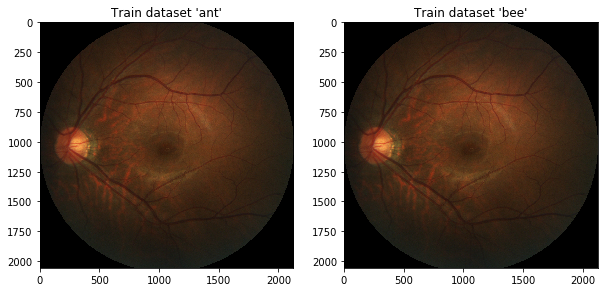

In [22]:
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.title("Train dataset 'ant'")
plt.imshow(train_A[10])
plt.subplot(122)
plt.title("Train dataset 'bee'")
plt.imshow(train_B[10])

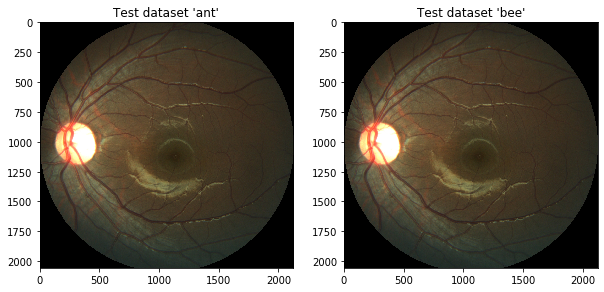

In [23]:
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.title("Test dataset 'ant'")
plt.imshow(test_A[0])
plt.subplot(122)
plt.title("Test dataset 'bee'")
plt.imshow(test_B[0])

In [24]:
class Image2ImageDataset(Dataset):    
    def __init__(self, ds_a, ds_b):
        self.dataset_a = ds_a
        self.dataset_b = ds_b
    
    def __len__(self):
        return max(len(self.dataset_a), len(self.dataset_b))

    def __getitem__(self, i):
        dp_a = self.dataset_a[i % len(self.dataset_a)]
        j = random.randint(0, len(self.dataset_b) - 1)
        dp_b = self.dataset_b[j]
        return {
            'A': dp_a,
            'B': dp_b
        }
class TransformedDataset(Dataset):        
    def __init__(self, ds, transform):
        self.dataset = ds
        self.transform = transform        
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, i):
        return {k: self.transform(v) for k, v in self.dataset[i].items()}

In [25]:
train_ab_ds = Image2ImageDataset(train_A, train_B)
test_ab_ds = Image2ImageDataset(test_A, test_B)

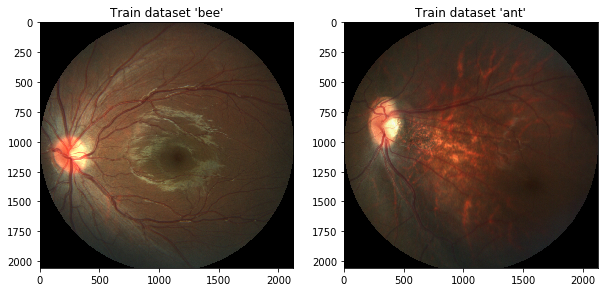

In [26]:
dp = train_ab_ds[20]
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.title("Train dataset 'bee'")
plt.imshow(dp['A'])
plt.subplot(122)
plt.title("Train dataset 'ant'")
plt.imshow(dp['B'])

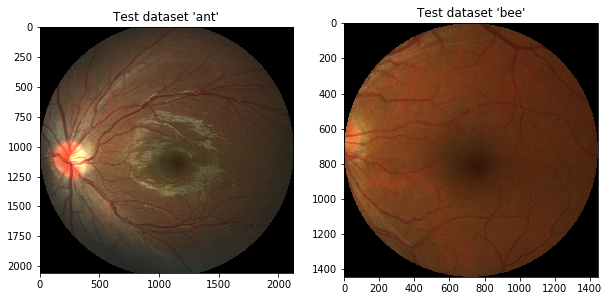

In [27]:
dp = test_ab_ds[20]
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.title("Test dataset 'ant'")
plt.imshow(dp['A'])
plt.subplot(122)
plt.title("Test dataset 'bee'")
plt.imshow(dp['B'])


In [28]:
train_transform = Compose([
    RandomCrop(200),
    RandomHorizontalFlip(),
    ColorJitter(),
    ToTensor(),
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])
transformed_train_ab_ds = TransformedDataset(train_ab_ds, transform=train_transform)

# Please select appropriate batch_size value according to your infrastructure
batch_size = 16
train_ab_loader = DataLoader(transformed_train_ab_ds, 
                             batch_size=batch_size, shuffle=True, 
                             drop_last=True, pin_memory=True, 
                             num_workers=8)

test_transform = Compose([
    ToTensor(),
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))])

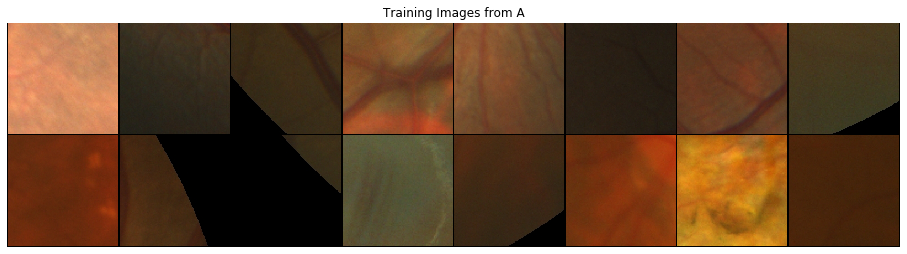

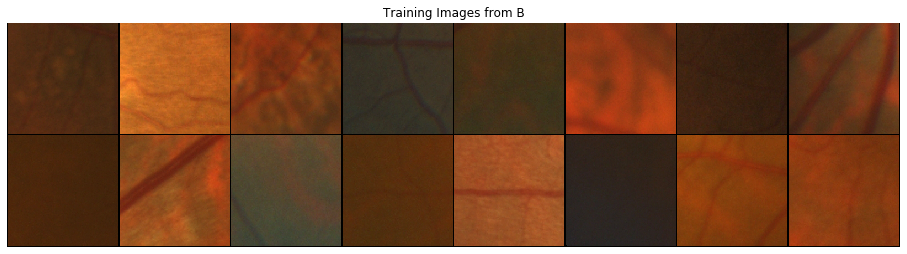

In [29]:
real_batch = next(iter(train_ab_loader))

plt.figure(figsize=(16, 8))
plt.axis("off")
plt.title("Training Images from A")
plt.imshow( 
    vutils.make_grid(real_batch['A'][:64], padding=2,
                     normalize=True).cpu().numpy().transpose((1, 2, 0))
)

plt.figure(figsize=(16, 8))
plt.axis("off")
plt.title("Training Images from B")
plt.imshow(
    vutils.make_grid(real_batch['B'][:64], padding=2, 
                     normalize=True).cpu().numpy().transpose((1, 2, 0))
)
real_batch = None
torch.cuda.empty_cache()
